
For an up-to-date version / full view of the plotly - plots, please, go to

Loan acceptance model: https://drive.google.com/file/d/1AK3SW55QoWe8Kwx-DipmdvwDRVLEFUHZ/view?usp=sharing

# LendingClub Prediction: Loan Acceptance



In this step I will predict the loan status of LendingClub's loan data.




## Imports

In [1]:
%%capture
! pip install scikit-learn==1.2.2 # need old version for eli5
! pip install xgboost==2.0.2

! pip install -q fastparquet==2024.2.0
! pip install -q dask==2023.8.1
! pip install -q pandas==1.5.3
! pip install -q numpy==1.25.2

! pip install -q eli5
! pip install -q shap
! pip install -q sklego

In [2]:
import numpy as np
import pandas as pd

import sys
import os
import warnings

from dask import dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (StandardScaler,
                                   OrdinalEncoder,
                                   OneHotEncoder,
                                   LabelEncoder)

#from imblearn.over_sampling import SMOTE, RandomOverSampler
#from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer #, KNNImputer

from sklearn.feature_selection import SelectKBest, f_classif #, #f_regression
#from sklearn.feature_selection import f_classif #, #f_regression
from sklearn.feature_selection import RFECV

from sklearn.model_selection import train_test_split
from sklearn.model_selection import (RepeatedKFold,
                                     StratifiedKFold,
                                     RepeatedStratifiedKFold)
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#from sklearn.metrics import confusion_matrix #for confusion matrix
#from sklearn.metrics import accuracy_score, f1_score

from scipy.stats import randint, loguniform, uniform

import copy

#from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
#from sklearn.experimental import enable_halving_search_cv # noqa
#from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

from tempfile import mkdtemp
from shutil import rmtree
from joblib import Memory

import eli5
from eli5.sklearn import PermutationImportance
import shap
#from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.classifier import (ROCAUC,
                                    PrecisionRecallCurve,
                                    DiscriminationThreshold)

from sklego.meta import Thresholder


import pickle


# Create a temporary folder to store the transformers of the pipeline
cachedir = mkdtemp()
memory = Memory(location=cachedir, verbose=False)


from google.colab import drive
drive.mount("/content/gdrive")

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

#pd.reset_option('display.max_rows')

Mounted at /content/gdrive


In [3]:
home_folder = '/content/gdrive/MyDrive/Colab Notebooks/Portfolio/ML_LendingClub/'

### Functions

The Python-file with the functions is at
https://drive.google.com/file/d/1JWLo8HAhUdu5xkDG4-tu7MiUSLgSxOjQ/view?usp=sharing


In [4]:
%load_ext autoreload
%autoreload 2

sys.path.append(home_folder)
import lendfunc as lfunc

In [5]:
! pip freeze > /content/gdrive/MyDrive/Colab\ Notebooks/Portfolio/ML_LendingClub/requirements.txt

# Model - Loan Acceptance

### Data Preparation

In [6]:
parquet_home_acc_cleaned = home_folder+'parquet_LCacc_cleaned/'
parquet_home_rej_cleaned = home_folder+'parquet_LCrej_cleaned/'

In [7]:
LCacc_dd = dd.read_parquet(parquet_home_acc_cleaned, ignore_metadata_file=True)
LCrej_dd = dd.read_parquet(parquet_home_rej_cleaned, ignore_metadata_file=True)

In [8]:
size_acc_dd = len(LCacc_dd)
size_rej_dd = len(LCrej_dd)
acc_rej_size_ratio = size_acc_dd/size_rej_dd

#### Create joint sample for Loan Applications

In [9]:
rej_cols = ['Amount Requested', 'Risk_Score', 'Zip Code', 'State',
       'Employment Length', 'applied_year', 'dti']

In [10]:
acc_cols = ['loan_amnt', 'fico_range_high', 'zip_code', 'addr_state',
       'emp_length', 'issue_d_year', 'dti']

In [11]:
rename_map={}
for rej, acc in zip(rej_cols, acc_cols):
    rename_map[acc] = rej

In [12]:
rejSAMPLES = 10000
frac_rej = rejSAMPLES/size_rej_dd

LCrej_dd_app =LCrej_dd[rej_cols].sample(frac=frac_rej, replace=False, random_state=10)
LCrej_dd_app['App_Status'] = 'rejected'

In [13]:
accSAMPLES = rejSAMPLES * acc_rej_size_ratio
frac_acc = accSAMPLES/size_acc_dd

LCacc_dd_app =LCacc_dd[acc_cols].sample(frac=frac_acc, replace=False, random_state=10)
LCacc_dd_app['App_Status'] = 'accepted'

In [14]:
LCrej_app = LCrej_dd_app.compute()
len(LCrej_app)

10002

In [15]:
LCacc_app = LCacc_dd_app.compute()
len(LCacc_app)

779

In [16]:
LCacc_app.rename(columns=rename_map, inplace=True)

In [17]:
LCapp = pd.concat([LCrej_app, LCacc_app], axis=0)

LCapp.reset_index(inplace=True, drop=True)


In [18]:
len(LCapp)

10781

In [19]:
LCapp.to_csv(home_folder+'cleaned/LendingClub_app_model.csv', index=False)

### Cross Validations and Score Metric Definitions

In [20]:
cvRK = RepeatedKFold(n_splits=5, n_repeats= 10, random_state=1)
cvSK = StratifiedKFold(n_splits=5, shuffle=False, random_state=None)
vSKs = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

cvRSK = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)

In [21]:
#scoring = 'r2' #'f1'
scoring = 'balanced_accuracy' #'f1_weighted'
#scoring = 'f1_macro'
#scoring = 'f1_weighted'
#scoring = 'roc_auc'  #crashes at RFECV

### Base Estimators

If computation time allows I am curious about the performances of as many classifiers as possible. Therefore I hold a collection of them ready to use.

DEFINE HERE THE SET OF CLASSIFIERS TO BE USED in this run:

In [22]:
classifiers=[#'Linear Svm','Radial Svm',
             'Logistic Regression',
             'KNN',
             'Decision Tree', #'Random Forest',
             'LightGBM', 'XGBoost'] #, 'CatBoost']

Base Classifier Setup

In [23]:
%reload_ext autoreload

# probability=True in SVMs needed for later scoring, but
# LinSVC = LinearSVC(random_state = 1, class_weight="balanced")
#  <-- cannot set probability=True for later scoring - replace by kernel SVC
LinSVC = SVC(kernel='linear', random_state = 1, class_weight="balanced",
             probability=True)
rbfSVC = SVC(kernel='rbf', random_state = 1, class_weight="balanced",
             probability=True)


#RandomizedSearch takes too long with probability=True
#--> create extra version for hypertuning
LinSVC_hypersearch = SVC(kernel='linear', random_state = 1, class_weight="balanced")
rbfSVC_hypersearch = SVC(kernel='rbf', random_state = 1, class_weight="balanced")


#LinReg = LinearRegression(n_jobs=-1)

LogReg = LogisticRegression(random_state = 1, n_jobs=-1,
                            class_weight="balanced")
KNNClas = KNeighborsClassifier(n_jobs=-1)
DTClas = DecisionTreeClassifier(random_state = 1,
                                class_weight="balanced")
RFClas = RandomForestClassifier(random_state = 1, n_jobs=-1,
                                class_weight="balanced", )
LGBMClas = lfunc.LGBMClassifierWithEarlyStop(random_state=1,
                                             class_weight="balanced",
                                             objective="binary",
                                             metric="binary_logloss",
                                             early_stopping_round=10,
                                             verbosity=-100,
                                             force_row_wise=True,
                                             #force_col_wise=True,
                                             )
#CatBClas = CatBoostClassifier(random_state=1, verbose=False)
XGBClas = lfunc.XGBoostClassifierWithEarlyStop(random_state=1,
                                               enable_categorical=False,
                                               eval_metric='binary_logloss',
                                               verbosity=0)

# estimators and their names
classifier_map = {'Linear Svm': LinSVC,
                  'Radial Svm': rbfSVC,
                  'Logistic Regression': LogReg,
                  'KNN': KNNClas,
                  'Decision Tree': DTClas,
                  'Random Forest': RFClas,
                  'LightGBM': LGBMClas,
                  'XGBoost': XGBClas
}

### Test Train Split

EDA-based selection of features:

In [24]:
LCapp.columns

Index(['Amount Requested', 'Risk_Score', 'Zip Code', 'State',
       'Employment Length', 'applied_year', 'dti', 'App_Status'],
      dtype='object')

'Zip Code', 'State', 'applied_year' most likely not helpful.

Construct the model data set and encode the labels

In [25]:
features = ['Amount Requested',
            'Risk_Score',
            'Employment Length',
            'dti'
            ]

X = LCapp[features]
y = LCapp['App_Status'].to_frame()

In [26]:
y['App_Status'].value_counts()

,App_Status
rejected,10002
accepted,779


In [27]:
LE = LabelEncoder()
y = LE.fit_transform(y)

labels = LE.classes_.tolist()
labels

['accepted', 'rejected']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0,
                                                    stratify = y) # <---- no stratify for cont. var!!!!!

X_train_analysis = X_train.copy()
X_test_analysis = X_test.copy()


### Preprocessor Setup

**Setup of the Ordinal Encoder**

Ranking information for Verification Status:

Verified income means that Lending Club independently verified both the source and size of reported income, source verified means that they verified only the source of the income, and not verified means there was no independent verification of the reported values.

https://michaeltoth.me/analyzing-historical-default-rates-of-lending-club-notes.html

In [29]:
ordinal_encode = {'Employment Length': ['< 1 year', '1 year', '2 years',
                                        '3 years', '4 years', '5 years',
                                        '6 years', '7 years', '8 years',
                                        '9 years', '10+ years']
                  }

ord_stepname_pre = "ord_"

ordinal_impute_step = ("imputer", SimpleImputer(strategy="most_frequent"))
ordinal_transformers=[]

for key in ordinal_encode.keys():
    ordinal_step = ('ordenc', OrdinalEncoder(handle_unknown="error",
                    categories = [ordinal_encode[key]]))
    ordinal_transformer = Pipeline(steps = [ordinal_impute_step,
                                            ordinal_step])
    ordinal_transformer_key = (ord_stepname_pre + key, ordinal_transformer, [key])
    ordinal_transformers.append(ordinal_transformer_key)

In [30]:
#### switch this here on and off for the use of ordinal encoding:
#ordinal_encode={}

**Setup of the Numerical and Categorical Transformers**

In [31]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())
           ]
)

categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("encoder", OneHotEncoder(handle_unknown="ignore")),
           ]
)

**Define the ColumnTransformer preprocessing Pipeline and gather the new Columns Names**

In [32]:
num_feat = X_train.select_dtypes(include=np.number).columns.tolist()
cat_feat = X_train.select_dtypes(exclude=np.number).columns.tolist()
ord_feat = ordinal_encode.keys()

# if ordinal, remove ordinal features from categorical feature list
if ordinal_encode:
    for feat in ord_feat:
        if feat in cat_feat:
            cat_feat.remove(feat)

# basic transformer
transformers=[("num", numeric_transformer, num_feat),
              ("cat", categorical_transformer, cat_feat)
              ]

# if ordinal, extend basic transformer
if ordinal_encode:
    transformers.extend(ordinal_transformers)


# THE PREPROCESSOR
preprocessor = ColumnTransformer(transformers=transformers,
                                 remainder='passthrough'
                                 )


# restoring the columns names after transform:
X_train_transformed = preprocessor.fit_transform(X_train)

new_cols = preprocessor.get_feature_names_out().tolist()

# rename ordinal
for key in ordinal_encode.keys():
   list_index = new_cols.index(ord_stepname_pre+key+"__"+key)
   new_cols[list_index] = ord_stepname_pre+"_"+key

# test if restoring worked (fails for inconsistent shape/length)
X_train_prep = pd.DataFrame(X_train_transformed, columns=new_cols)

Turn proprocessor into general pipeline steps to which the next steps can be appended, e.g. over/undersampling, classifier.


In [33]:
X_transformer_steps = [('preprocessor', preprocessor)]

# general pipeline preprocessing steps, i.e. append over/undersampling
pipe_prep_steps = X_transformer_steps.copy()

In [34]:
print('The number of features increased from', len(X_train.columns), 'to',
      len(X_train_prep.columns), 'after preprocessing.' )
#len(X_train.columns), len(X_train_prep.columns)

The number of features increased from 4 to 4 after preprocessing.


In [35]:
# how to access infos:
# preprocessor.transformers[0][2]

### Feature Selection

This is rather a try-out. Goal was to see if SelectKBest, RidgeCV, and RFE find the same features.



#### SelectKBest

In [36]:
pipe_steps = pipe_prep_steps.copy()
pipe_steps.append(('f_classif', SelectKBest(score_func=f_classif, k=3)))

KBest_pipe = Pipeline(pipe_steps)

KBest_pipe.fit(X_train,y_train)


KBest = KBest_pipe.named_steps['f_classif'].get_feature_names_out()

KBest_cols = []
for feature in KBest:
    index_nr = int(feature.replace('x', ''))
    KBest_cols.append(new_cols[index_nr])

KBest_cols

['num__Amount Requested', 'num__Risk_Score', 'ord__Employment Length']

#### RidgeCV

Another try-out: a regularization algorithm that returns features importances:

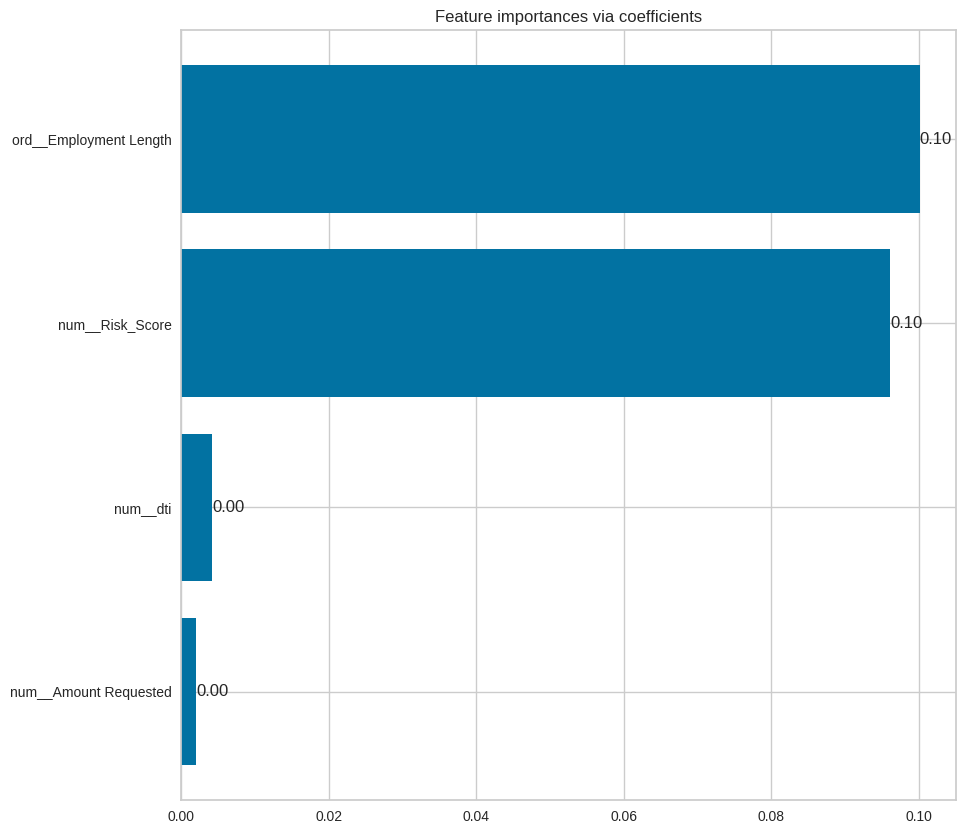

In [37]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import RidgeCV, RidgeClassifierCV

ridge = RidgeClassifierCV(alphas=np.logspace(-6, 6, num=5),
                          scoring = scoring, cv = cvSK)

pipe_steps = pipe_prep_steps.copy()
pipe_steps.append(('Feature Selection', ridge))

ridge_pipeline = Pipeline(pipe_steps)

ridge_pipeline.fit(X_train,y_train)

importance = np.abs(ridge.coef_[0])

ridge_df = pd.DataFrame(importance,index=new_cols,columns=['Importance'])#.sort_values(by='Rank',ascending=True)
ridge_df.reset_index(inplace=True)
ridge_df = ridge_df.sort_values(by='Importance',ascending=False)



fig = plt.figure(figsize=(10,10))
ax = fig.gca()  # define axis

hbars = ax.barh(ridge_df['index'][:20], ridge_df['Importance'][:20], align='center')
ax.set_title("Feature importances via coefficients")
ax.invert_yaxis()
ax.bar_label(hbars, fmt='%.2f')
#ax.set_xlim(right=0.107)  # adjust xlim to fit labels

plt.show()



In [38]:
ridge_df['index'][:20].sort_values().values.tolist()

['num__Amount Requested',
 'num__Risk_Score',
 'num__dti',
 'ord__Employment Length']

In [39]:
KBest_cols.sort()
KBest_cols

['num__Amount Requested', 'num__Risk_Score', 'ord__Employment Length']

#### Recursive Feature Elimination (RFECV)

Attempt to reduce the number of features through recursive feature elimination:

In [40]:
%%time
# the error:  "when importance_getter=='auto', the underlying estimator X
# should have 'coef_' or 'feature_importances_' attribute."
# limits the pool of estimator that are easy to use:

#model = LinReg
#model = LogReg
#model = RFClas
#model = LinSVC
model = DTClas


rfecv = RFECV(estimator=model,
              #cv=cvRSK,  ### takes ages!!! >13min
              cv=cvSK, # for classification
              #cv=cvRK, # for regression
              scoring = scoring
              )


pipeline = Pipeline([('preprocessor', preprocessor),
                     ('Feature Selection', rfecv)
                     ])

pipeline.fit(X_train,y_train)

rfecv_df = pd.DataFrame(rfecv.ranking_,index=new_cols,columns=['Rank'])
rfecv_df.reset_index(inplace=True)
rfecv_df = rfecv_df.sort_values(by='Rank',ascending=True)
rfecv_df

CPU times: user 270 ms, sys: 2.33 ms, total: 273 ms
Wall time: 279 ms


,index,Rank
1,num__Risk_Score,1
2,num__dti,2
3,ord__Employment Length,3
0,num__Amount Requested,4


In [41]:
mean_score = np.max(rfecv.cv_results_["mean_test_score"]).round(5)
print('The mean', scoring, 'scoring is:', mean_score)

The mean balanced_accuracy scoring is: 0.98414


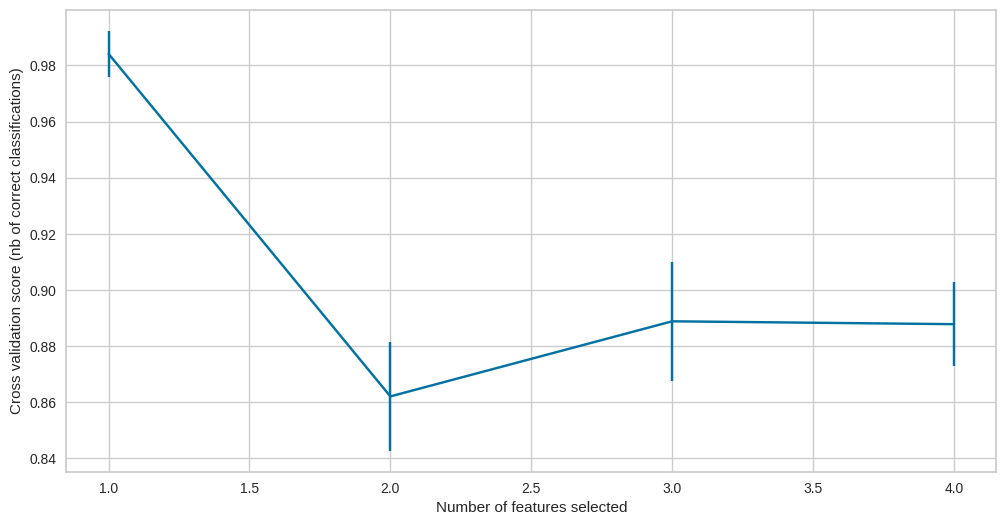

In [42]:
plt.figure(figsize=(12,6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (nb of correct classifications)')
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.show()

In [43]:
#rfecv.cv_results_["mean_test_score"].round(3)

### Scores per Basic Model BEFORE Hyperparameter Tuning

First, we do a crossvalidation on support vector machines, logistic regression, k-nearest neighbors, decision tree, and random forest, LightGBM, and XGBoost algorithms with their default parameters to see where we stand.

In [44]:
%%time
%reload_ext autoreload

estimators_basic = []
for clas in classifiers:
    estimators_basic.append(classifier_map[clas])

models_basic=[]
for estimator in estimators_basic:
    pipe_steps = pipe_prep_steps.copy()
    pipe_steps.append(('classifier' , estimator))
    models_basic.append(Pipeline(pipe_steps))

model_cv_results_before = lfunc.model_scores(X_train,y_train,X_test,
                                      models = models_basic,
                                      model_names = classifiers,
                                      cv = cvRSK)

(model_performance_before,
 collect_cv_results_before,
 model_prob_before) = model_cv_results_before

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
[3]	validation_0-logloss:0.12008
[4]	validation_0-logloss:0.10392
[5]	validation_0-logloss:0.09343
[6]	validation_0-logloss:0.08629
[7]	validation_0-logloss:0.08204
[8]	validation_0-logloss:0.07824
[9]	validation_0-logloss:0.07517
[10]	validation_0-logloss:0.07320
[11]	validation_0-logloss:0.07072
[12]	validation_0-logloss:0.06996
[13]	validation_0-logloss:0.06866
[14]	validation_0-logloss:0.06876
[15]	validation_0-logloss:0.06875
[16]	validation_0-logloss:0.06693
[17]	validation_0-logloss:0.06698
[18]	validation_0-logloss:0.06521
[19]	validation_0-logloss:0.06341
[20]	validation_0-logloss:0.06240
[21]	validation_0-logloss:0.06189
[22]	validation_0-logloss:0.06186
[23]	validation_0-logloss:0.06161
[24]	validation_0-logloss:0.06049
[25]	validation_0-logloss:0.06007
[26]	validation_0-logloss:0.06042
[27]	validation_0-logloss:0.06030
[28]	validation_0-logloss:0.06100
[29]	validation_0-logloss:0.06136
[30]	validation_0-logl

In [45]:
model_performance_before.round(3)

,accuracy mean,accuracy std,balanced accuracy mean,balanced accuracy std,f1 mean,f1 std,f1 micro mean,f1 micro std,f1 macro mean,f1 macro std,f1 weighted mean,f1 weighted std,precision mean,precision std,precision micro mean,precision micro std,precision macro mean,precision macro std,precision weighted mean,precision weighted std,average precision mean,average precision std,recall mean,recall std,recall micro mean,recall micro std,recall macro mean,recall macro std,recall weighted mean,recall weighted std,roc auc mean,roc auc std,roc auc ovr mean,roc auc ovr std,roc auc ovo mean,roc auc ovo std,roc auc ovr weighted mean,roc auc ovr weighted std,roc auc ovo weighted mean,roc auc ovo weighted std
Logistic Regression,0.920,0.006,0.899,0.015,0.956,0.004,0.920,0.006,0.785,0.014,0.931,0.005,0.989,0.002,0.920,0.006,0.732,0.013,0.952,0.003,0.997,0.000,0.924,0.006,0.920,0.006,0.899,0.015,0.920,0.006,0.960,0.005,0.960,0.005,0.960,0.005,0.960,0.005,0.960,0.005
KNN,0.971,0.003,0.881,0.020,0.984,0.002,0.971,0.003,0.889,0.014,0.970,0.004,0.983,0.003,0.971,0.003,0.898,0.016,0.970,0.004,0.993,0.002,0.986,0.003,0.971,0.003,0.881,0.020,0.971,0.003,0.949,0.012,0.949,0.012,0.949,0.012,0.949,0.012,0.949,0.012
Decision Tree,0.970,0.003,0.883,0.017,0.984,0.002,0.970,0.003,0.886,0.013,0.969,0.003,0.983,0.003,0.970,0.003,0.889,0.015,0.969,0.003,0.982,0.003,0.984,0.003,0.970,0.003,0.883,0.017,0.970,0.003,0.883,0.017,0.883,0.017,0.883,0.017,0.883,0.017,0.883,0.017
LightGBM,0.975,0.004,0.950,0.012,0.986,0.002,0.975,0.004,0.914,0.012,0.976,0.004,0.994,0.002,0.975,0.004,0.884,0.017,0.978,0.003,1.000,0.000,0.979,0.004,0.975,0.004,0.950,0.012,0.975,0.004,0.994,0.001,0.994,0.001,0.994,0.001,0.994,0.001,0.994,0.001
XGBoost,0.978,0.003,0.920,0.017,0.988,0.002,0.978,0.003,0.918,0.012,0.978,0.003,0.988,0.003,0.978,0.003,0.916,0.015,0.978,0.003,0.999,0.000,0.988,0.003,0.978,0.003,0.920,0.017,0.978,0.003,0.993,0.001,0.993,0.001,0.993,0.001,0.993,0.001,0.993,0.001


Reminder:
* Precision = TP / (TP + FP)
* Recall = TP / (TP + FN)

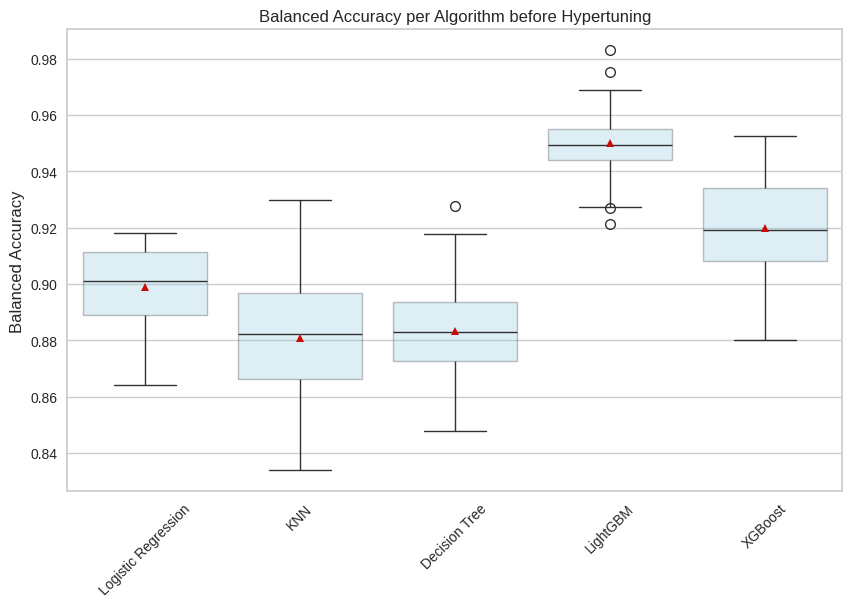

In [46]:
score_metric = scoring
lfunc.plot_model_score([collect_cv_results_before],
                 score = score_metric, classifiers_names = classifiers,
                 colors = ['skyblue'], tilt_x = True,
                 title = score_metric.replace('_',' ').title()+
                        ' per Algorithm before Hypertuning')  ;

#### Confusion Matrices before Hypertune

''

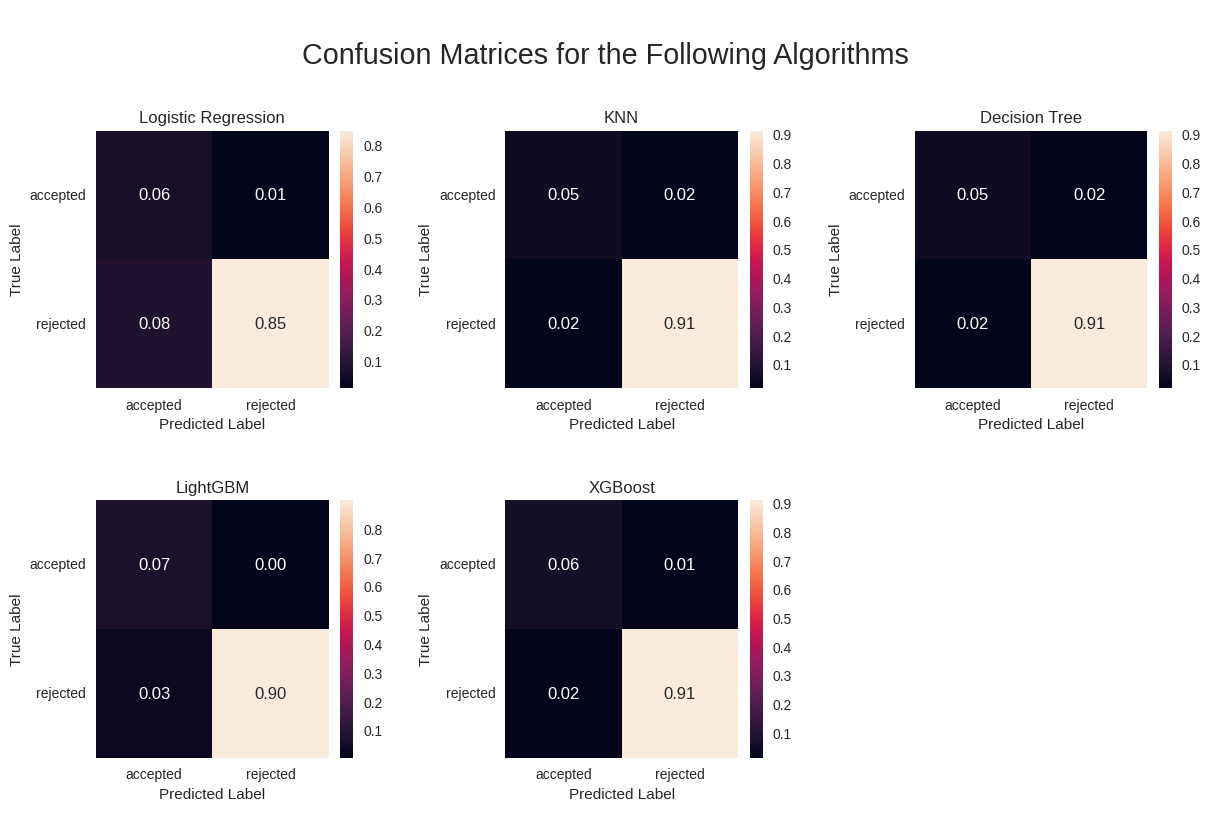

In [47]:
%reload_ext autoreload

lfunc.plot_confusion_matrices(model_prob_before,y_test,
                              names = classifiers,
                              n_cols = 3, normalize = 'all', labels = labels,
                              title = 'for the Following Algorithms')
;

## Hyperparameter Tuning with RandomizedSearchCV

In [48]:
classifiers_h = classifiers

In a previous project, I have made the function 'hyper_search' to loop over the given estimators and several (grid-)search-varieties ('Grid', 'HalvingGrid', 'Random', 'HalvingRandom').
In the following, I will focus on RandomizedSearchCV, which performed best in the previous projects.

The dummy estimator in the pipeline will be replaced by the classifiers in the hyperparameter dictionaries

In [49]:
pipe_steps = pipe_prep_steps.copy()
pipe_steps.append(('classifier' , RandomForestClassifier()))

pipe = Pipeline(pipe_steps, memory=memory)   # cache pipeline results except from last step

In the following, I create the parameter distribution for Randomized SearchCV per classifier. Since XGBoost and LightGBM are fast, I let them test more parameters.

In [50]:
%reload_ext autoreload

# Create param distribution (Randomized Search) per classifier

hyper_distro_XGB = {
          'classifier' : [XGBClas],
          "classifier__n_estimators": randint(50, 1000),
          "classifier__max_depth": randint(1, 10),
          "classifier__scale_pos_weight": uniform(1, 30),
          "classifier__learning_rate": uniform(0.05, 0.2),
          'classifier__early_stopping_rounds': randint(5, 10),
          "classifier__min_child_weight": randint(1, 12),       # min. number of obs. (hessians) in a node to make split
          "classifier__gamma": uniform(0, 1),                   # L0 regularization - dep. on number of leaves
          "classifier__reg_alpha": uniform(0, 1),               # L1 regularization
          "classifier__reg_lambda": uniform(loc=0, scale=1),    # L2 regularization
          "classifier__subsample": uniform(0.1, 1),
          "classifier__colsample_bytree": uniform(0.1, 1),

      }

#hyper_distro_CatB = {
#        'classifier' : [CatBClas],
#        "classifier__n_estimators":      randint(50, 1000),
#        "classifier__depth":             randint(1, 12),
#        "classifier__colsample_bylevel": uniform(0.1, 1),
#        "classifier__boosting_type":     ["Ordered", "Plain"],
#        "classifier__bootstrap_type":    ["Bayesian", "Bernoulli", "MVS"],
#        'classifier__early_stopping_rounds': randint(1, 10),
#        "classifier__random_strength":   loguniform(1e-4, 10.0),
#        "classifier__l2_leaf_reg":       loguniform(1e-8, 10.0),
#        #"classifier__bagging_temperature": uniform(0, 10), # if param["bootstrap_type"] == "Bayesian"
#        #"classifier__subsample": uniform(0.1, 1),          # if param["bootstrap_type"] == "Bernoulli"
#      }

hyper_distro_LightGBM = {
        'classifier' : [LGBMClas],
        "classifier__n_estimators": randint(50, 1000),
        "classifier__max_depth": randint(1, 12),
        "classifier__boosting_type": ["gbdt"],
        "classifier__learning_rate": uniform(0.05, 0.2),
        "classifier__lambda_l1": loguniform(1e-8, 10.0),
        "classifier__lambda_l2": loguniform(1e-8, 10.0),
        "classifier__num_leaves": randint(2, 256),
        'classifier__early_stopping_round': randint(1, 10),
        "classifier__feature_fraction": uniform(0.4, 1.0),
        "classifier__bagging_fraction": uniform(0.4, 1.0),
        "classifier__bagging_freq": randint(1, 7),
        "classifier__min_child_samples": randint(5, 100),

        }

hyper_distro_LinSVC = {'classifier' : [LinSVC_hypersearch],
     'classifier__C' : loguniform(0.01, 1e3)}

hyper_distro_rbfSVC = {'classifier' : [rbfSVC_hypersearch],
     'classifier__kernel' : ['rbf'],
     'classifier__C' : loguniform(0.01, 1e3),
     'classifier__gamma': loguniform(0.01, 1e3)}

hyper_distro_LogReg = {'classifier' : [LogReg],
     'classifier__C' : loguniform(0.01, 1e3)}

hyper_distro_KNN = {'classifier' : [KNNClas],
             'classifier__n_neighbors' : randint(1, 21),
             'classifier__weights' : ['uniform','distance'],
             'classifier__metric' : ['minkowski','euclidean','manhattan']}

#https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680
hyper_distro_DTC = {'classifier' : [DTClas],
     'classifier__min_samples_split' : randint(10, 41),
     'classifier__min_samples_leaf' : randint(1, 21)}

hyper_distro_RFC = {'classifier' : [RFClas],
     'classifier__n_estimators' : randint(10, 1000),
     #'classifier__max_features': ['sqrt', 'log2', None],
     #'classifier__max_depth': randint(1, 10),
     #'classifier__max_leaf_nodes': randint(1, 10)
                    }


# Classifiers and their corresponding hyperparameter setup
param_distro_map = {'Linear Svm': hyper_distro_LinSVC,
                  'Radial Svm': hyper_distro_rbfSVC,
                  'Logistic Regression': hyper_distro_LogReg,
                  'KNN': hyper_distro_KNN,
                  'Decision Tree': hyper_distro_DTC,
                  'Random Forest': hyper_distro_RFC,
                  'LightGBM': hyper_distro_LightGBM,
                  'XGBoost': hyper_distro_XGB
}

# hyperparameter setups used in this run:
param_distro = []
for clas in classifiers_h:
    param_distro.append(param_distro_map[clas])

**Derive the Hyperparameters**

In [51]:
%%time
%reload_ext autoreload

start = 0
stop = 4

hyper_params = lfunc.hyper_search(pipe,  X_train, y_train,
                            param_distributions = param_distro, #[start:stop],
                            classifier_names = classifiers,#[start:stop],
                            cv = cvSK, niter = 20,
                            searches = ['Random'],
                            scoring = scoring,
                            verbose=0)

Executing Logistic Regression
for search method: Random
best score: 0.903
best parameters: {'classifier': LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=1), 'classifier__C': 4.877726266856736}
 
Executing KNN
for search method: Random
best score: 0.886
best parameters: {'classifier': KNeighborsClassifier(n_jobs=-1), 'classifier__metric': 'manhattan', 'classifier__n_neighbors': 16, 'classifier__weights': 'uniform'}
 
Executing Decision Tree
for search method: Random
best score: 0.959
best parameters: {'classifier': DecisionTreeClassifier(class_weight='balanced', random_state=1), 'classifier__min_samples_leaf': 6, 'classifier__min_samples_split': 40}
 
Executing LightGBM
for search method: Random
best score: 0.969
best parameters: {'classifier': LGBMClassifierWithEarlyStop(boosting_type='gbdt', class_weight='balanced',
                            colsample_bytree=1.0, early_stopping_round=10,
                            force_row_wise=True, importance_type='split',
 

In [52]:
hyper_params

,classifier,search method,best score,time[s],best params
0,Logistic Regression,Random,0.903,4.2,"{'classifier': LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=1), 'classifier__C': 4.877726266856736}"
1,KNN,Random,0.886,13.1,"{'classifier': KNeighborsClassifier(n_jobs=-1), 'classifier__metric': 'manhattan', 'classifier__n_neighbors': 16, 'classifier__weights': 'uniform'}"
2,Decision Tree,Random,0.959,2.1,"{'classifier': DecisionTreeClassifier(class_weight='balanced', random_state=1), 'classifier__min_samples_leaf': 6, 'classifier__min_samples_split': 40}"
3,LightGBM,Random,0.969,8.5,"{'classifier': LGBMClassifierWithEarlyStop(boosting_type='gbdt', class_weight='balanced', colsample_bytree=1.0, early_stopping_round=10, force_row_wise=True, importance_type='split', learning_rate=0.1, max_depth=-1, metric='binary_logloss', min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0, n_estimators=100, n_jobs=None, num_leaves=31, objective='binary', random_state=1, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0, subsample_for_bin=200000, subsample_freq=0, verbosity=-100), 'classifier__bagging_fraction': 0.9435060776707007, 'classifier__bagging_freq': 3, 'classifier__boosting_type': 'gbdt', 'classifier__early_stopping_round': 4, 'classifier__feature_fraction': 0.982283081244809, 'classifier__lambda_l1': 0.041105676423791794, 'classifier__lambda_l2': 0.41162353845724853, 'classifier__learning_rate': 0.08517828798604898, 'classifier__max_depth': 3, 'classifier__min_child_samples': 6, 'classifier__n_estimators': 961, 'classifier__num_leaves': 88}"
4,XGBoost,Random,0.911,14.3,"{'classifier': XGBoostClassifierWithEarlyStop(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, objective='binary:logistic', ...), 'classifier__colsample_bytree': 0.8619623125184942, 'classifier__early_stopping_rounds': 8, 'classifier__gamma': 0.7374597038900097, 'classifier__learning_rate': 0.14175709968250919, 'classifier__max_depth': 4, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 475, 'classifier__reg_alpha': 0.814671058444582, 'classifier__reg_lambda': 0.8725471276050031, 'classifier__scale_pos_weight': 1.9808772625302176, 'classifier__subsample': 0.9382125668022399}"


Extract the best tuned hyperparameters per classifier:

In [53]:
param_classifiers={}


for classifier in classifiers_h:
    param_classifier = hyper_params.loc[(hyper_params['classifier']==classifier)]
    param_classifier = param_classifier.loc[param_classifier['best score']==param_classifier['best score'].max()]['best params'].values[0]
    # replace the 'classifier__' in the keys --> can insert best params directly into untuned classifiers
    if 'classifier' in param_classifier.keys():
        param_classifier.pop('classifier')
    new_keys = [key.replace('classifier__','') for key in param_classifier.keys()]
    param_classifier = dict(zip(new_keys, list(param_classifier.values())))
    print(param_classifier)
    param_classifiers[classifier] = param_classifier

{'C': 4.877726266856736}
{'metric': 'manhattan', 'n_neighbors': 16, 'weights': 'uniform'}
{'min_samples_leaf': 6, 'min_samples_split': 40}
{'bagging_fraction': 0.9435060776707007, 'bagging_freq': 3, 'boosting_type': 'gbdt', 'early_stopping_round': 4, 'feature_fraction': 0.982283081244809, 'lambda_l1': 0.041105676423791794, 'lambda_l2': 0.41162353845724853, 'learning_rate': 0.08517828798604898, 'max_depth': 3, 'min_child_samples': 6, 'n_estimators': 961, 'num_leaves': 88}
{'colsample_bytree': 0.8619623125184942, 'early_stopping_rounds': 8, 'gamma': 0.7374597038900097, 'learning_rate': 0.14175709968250919, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 475, 'reg_alpha': 0.814671058444582, 'reg_lambda': 0.8725471276050031, 'scale_pos_weight': 1.9808772625302176, 'subsample': 0.9382125668022399}


##### Update the base classifiers with the hypertuned parameters:

In [54]:
%%capture

LinSVC_h = copy.deepcopy(LinSVC_hypersearch)
if 'Linear Svm' in param_classifiers.keys():
    # probability=True in SVMs needed for later scoring:
    LinSVC_h.set_params(**param_classifiers['Linear Svm'], probability=True)

rbfSVC_h = copy.deepcopy(rbfSVC_hypersearch)
if 'Radial Svm' in param_classifiers.keys():
    rbfSVC_h.set_params(**param_classifiers['Radial Svm'], probability=True)

LogReg_h = copy.deepcopy(LogReg)
if 'Logistic Regression' in param_classifiers.keys():
    LogReg_h.set_params(**param_classifiers['Logistic Regression'])

KNNClas_h = copy.deepcopy(KNNClas)
if 'KNN' in param_classifiers.keys():
    KNNClas_h.set_params(**param_classifiers['KNN'])

DTClas_h = copy.deepcopy(DTClas)
if 'Decision Tree' in param_classifiers.keys():
    DTClas_h.set_params(**param_classifiers['Decision Tree'])

RFClas_h = copy.deepcopy(RFClas)
if 'Random Forest' in param_classifiers.keys():
    RFClas_h.set_params(**param_classifiers['Random Forest'])

LGBMClas_h = copy.deepcopy(LGBMClas)
if 'LightGBM' in param_classifiers.keys():
    LGBMClas_h.set_params(**param_classifiers['LightGBM'])

# active when enough time to compile:
# CatBClas_h = CatBClas
#if 'CatBoost' in param_classifiers.keys():
    # CatBClas_h.set_params(**param_classifiers['CatBoost'])

XGBClas_h = copy.deepcopy(XGBClas)
if 'XGBoost' in param_classifiers.keys():
    XGBoost_param_fit={}
    # cross_val_score cannot deal with 'early_stopping_rounds'
    # ---> put it into fit_params for the fit-function:
    if 'early_stopping_rounds' in param_classifiers['XGBoost']:
        XGBoost_param_fit['classifier__early_stopping_rounds'] = param_classifiers['XGBoost']['early_stopping_rounds']
        param_classifiers['XGBoost'].pop('early_stopping_rounds')
    XGBClas_h.set_params(**param_classifiers['XGBoost'])



# hypertuned estimators and their names
classifier_map_h = {'Linear Svm': LinSVC_h,
                  'Radial Svm': rbfSVC_h,
                  'Logistic Regression': LogReg_h,
                  'KNN': KNNClas_h,
                  'Decision Tree': DTClas_h,
                  'Random Forest': RFClas_h,
                  'LightGBM': LGBMClas_h,
                  'XGBoost': XGBClas_h
}

## Scores per Basic Model AFTER Hyperparameter Tuning

Let's redo the crossvalidation on the algorithms with their now tuned parameters.

In [55]:
#classifiers_h =[#'KNN',
# #'Decision Tree',
# 'LightGBM']

In [56]:
%%time
%reload_ext autoreload

estimators_hyped = []
for clas in classifiers_h:
    estimators_hyped.append(classifier_map_h[clas])

models_hyped=[]
fit_params_hyped=[]
for estimator in estimators_hyped:
    pipe_steps = pipe_prep_steps.copy()
    pipe_steps.append(('classifier' , estimator))
    models_hyped.append(Pipeline(pipe_steps))

    if estimator == XGBClas_h:
        fit_params_hyped.append(XGBoost_param_fit)
    else:
        fit_params_hyped.append(None)

model_cv_results_after = lfunc.model_scores(X_train,y_train,X_test,
                                      models = models_hyped,
                                      model_names = classifiers_h,
                                      fit_params = fit_params_hyped,
                                      cv = cvRSK)

(model_performance_after,
 collect_cv_results_after,
 model_prob_after) = model_cv_results_after

Executing Logistic Regression
Executing KNN
Executing Decision Tree
Executing LightGBM
Executing XGBoost
[0]	validation_0-logloss:0.24277
[1]	validation_0-logloss:0.20403
[2]	validation_0-logloss:0.18569
[3]	validation_0-logloss:0.16424
[4]	validation_0-logloss:0.15257
[5]	validation_0-logloss:0.14017
[6]	validation_0-logloss:0.12763
[7]	validation_0-logloss:0.11701
[8]	validation_0-logloss:0.10870
[9]	validation_0-logloss:0.10194
[10]	validation_0-logloss:0.09655
[11]	validation_0-logloss:0.09086
[12]	validation_0-logloss:0.08600
[13]	validation_0-logloss:0.08251
[14]	validation_0-logloss:0.07969
[15]	validation_0-logloss:0.07656
[16]	validation_0-logloss:0.07414
[17]	validation_0-logloss:0.07219
[18]	validation_0-logloss:0.07001
[19]	validation_0-logloss:0.06889
[20]	validation_0-logloss:0.06838
[21]	validation_0-logloss:0.06682
[22]	validation_0-logloss:0.06546
[23]	validation_0-logloss:0.06452
[24]	validation_0-logloss:0.06374
[25]	validation_0-logloss:0.06278
[26]	validation_0-log

In [57]:
model_performance_after.round(3)

,accuracy mean,accuracy std,balanced accuracy mean,balanced accuracy std,f1 mean,f1 std,f1 micro mean,f1 micro std,f1 macro mean,f1 macro std,f1 weighted mean,f1 weighted std,precision mean,precision std,precision micro mean,precision micro std,precision macro mean,precision macro std,precision weighted mean,precision weighted std,average precision mean,average precision std,recall mean,recall std,recall micro mean,recall micro std,recall macro mean,recall macro std,recall weighted mean,recall weighted std,roc auc mean,roc auc std,roc auc ovr mean,roc auc ovr std,roc auc ovo mean,roc auc ovo std,roc auc ovr weighted mean,roc auc ovr weighted std,roc auc ovo weighted mean,roc auc ovo weighted std
Logistic Regression,0.921,0.007,0.901,0.015,0.956,0.004,0.921,0.007,0.785,0.014,0.931,0.005,0.990,0.002,0.921,0.007,0.732,0.013,0.953,0.003,0.997,0.000,0.924,0.007,0.921,0.007,0.901,0.015,0.921,0.007,0.961,0.005,0.961,0.005,0.961,0.005,0.961,0.005,0.961,0.005
KNN,0.973,0.004,0.885,0.017,0.985,0.002,0.973,0.004,0.895,0.013,0.972,0.004,0.983,0.003,0.973,0.004,0.907,0.017,0.972,0.004,0.997,0.001,0.988,0.003,0.973,0.004,0.885,0.017,0.973,0.004,0.973,0.009,0.973,0.009,0.973,0.009,0.973,0.009,0.973,0.009
Decision Tree,0.958,0.006,0.958,0.009,0.977,0.003,0.958,0.006,0.872,0.014,0.962,0.005,0.997,0.002,0.958,0.006,0.819,0.017,0.971,0.003,0.997,0.001,0.958,0.006,0.958,0.006,0.958,0.009,0.958,0.006,0.978,0.008,0.978,0.008,0.978,0.008,0.978,0.008,0.978,0.008
LightGBM,0.959,0.007,0.969,0.007,0.978,0.004,0.959,0.007,0.878,0.018,0.963,0.006,0.998,0.001,0.959,0.007,0.822,0.023,0.973,0.003,1.000,0.000,0.958,0.008,0.959,0.007,0.969,0.007,0.959,0.007,0.994,0.002,0.994,0.002,0.994,0.002,0.994,0.002,0.994,0.002
XGBoost,0.980,0.003,0.911,0.018,0.989,0.002,0.980,0.003,0.924,0.012,0.980,0.003,0.987,0.003,0.980,0.003,0.938,0.013,0.980,0.003,1.000,0.000,0.992,0.002,0.980,0.003,0.911,0.018,0.980,0.003,0.994,0.001,0.994,0.001,0.994,0.001,0.994,0.001,0.994,0.001


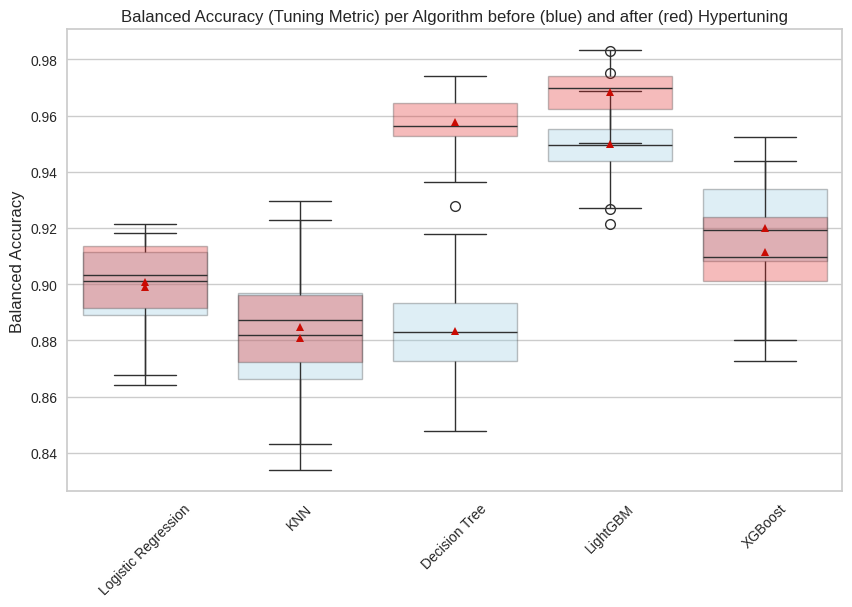

In [58]:
score_metric = scoring
lfunc.plot_model_score([collect_cv_results_before, collect_cv_results_after],
                 score = score_metric, classifiers_names = classifiers_h,
                 colors = ['skyblue', 'red'], tilt_x = True,
                 title = score_metric.replace('_',' ').title()+
                        ' (Tuning Metric) per Algorithm before (blue) '+
                        'and after (red) Hypertuning')  ;

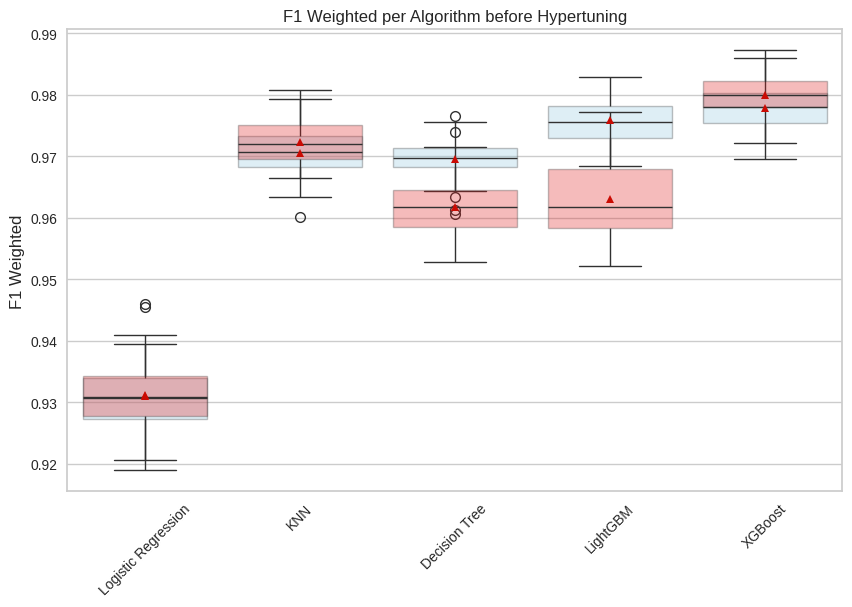

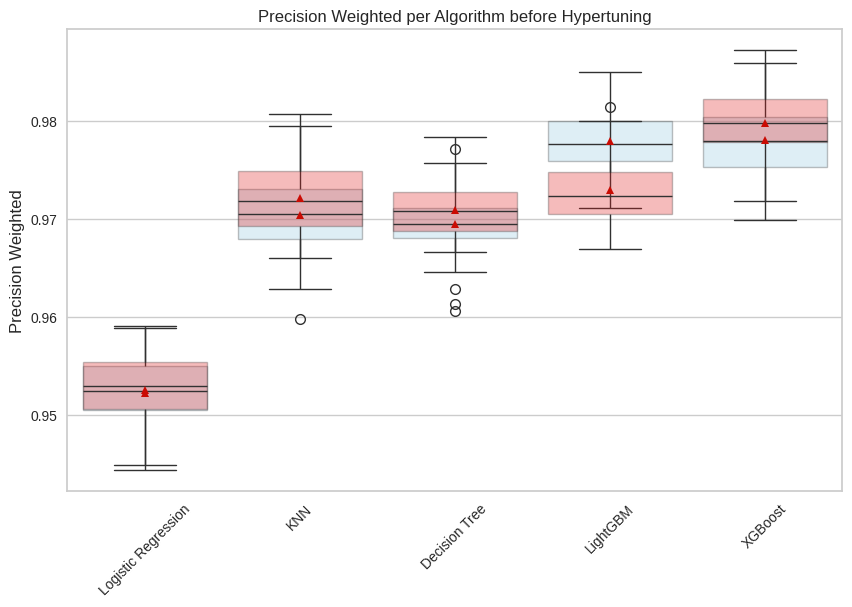

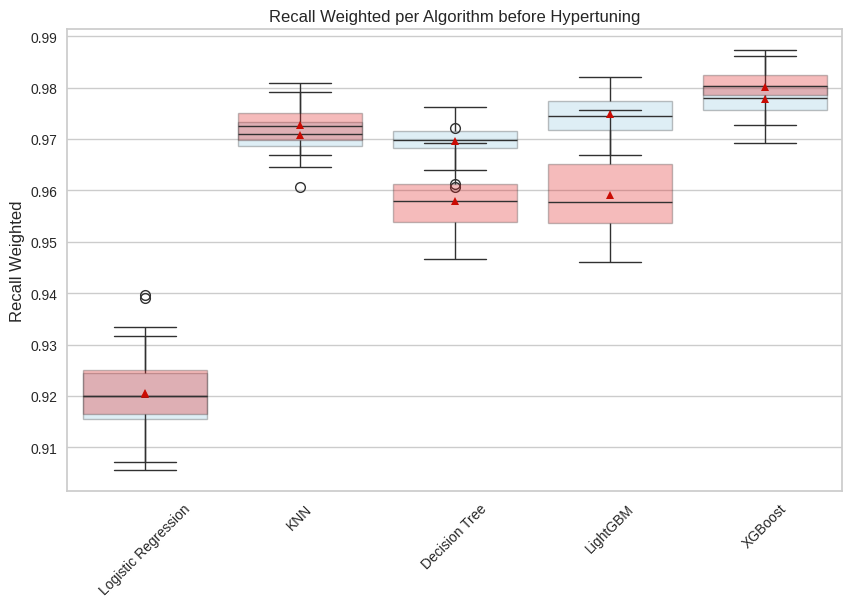

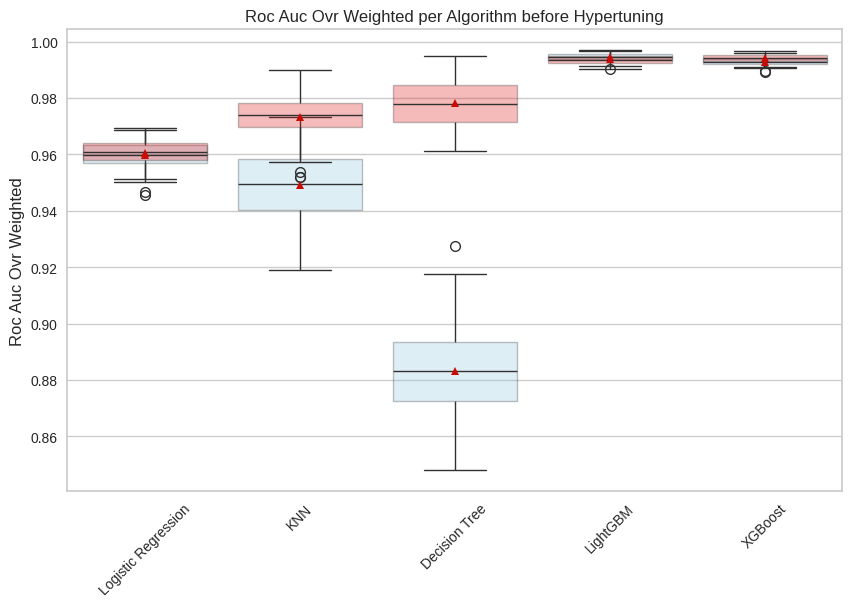

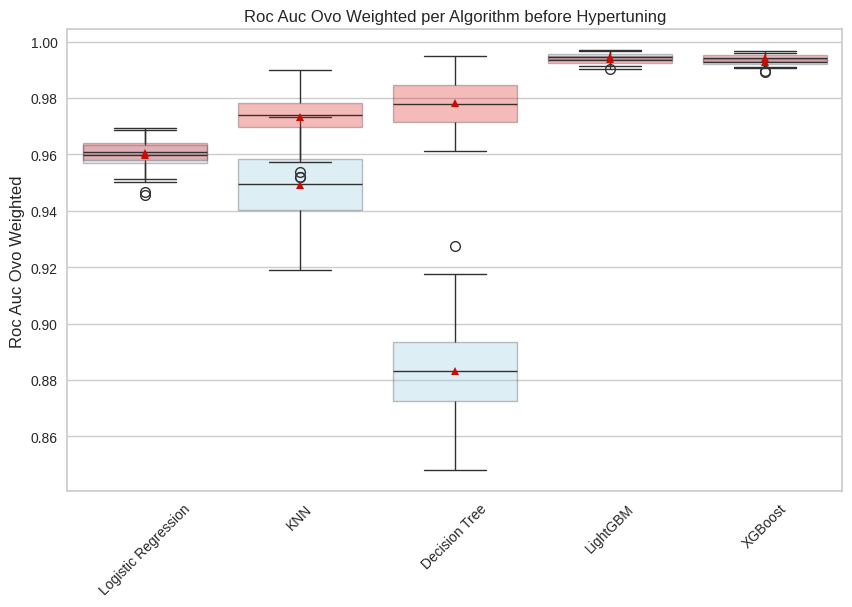

In [59]:
score_metrics = ['balanced_accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted',
                 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted']

for score_metric in score_metrics:
    if score_metric is not scoring:
        lfunc.plot_model_score([collect_cv_results_before, collect_cv_results_after],
                 score = score_metric, classifiers_names = classifiers_h,
                 colors = ['skyblue', 'red'], tilt_x = True,
                 title = score_metric.replace('_',' ').title()+
                        ' per Algorithm before Hypertuning')  ;

In [60]:
from sklearn.metrics import classification_report
y_pred = (model_prob_after[-1][:, 1] > 0.5)#.astype("float")
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.78      0.80       156
           1       0.98      0.99      0.98      2001

    accuracy                           0.97      2157
   macro avg       0.90      0.88      0.89      2157
weighted avg       0.97      0.97      0.97      2157



#### Confusion Matrices after Hypertune

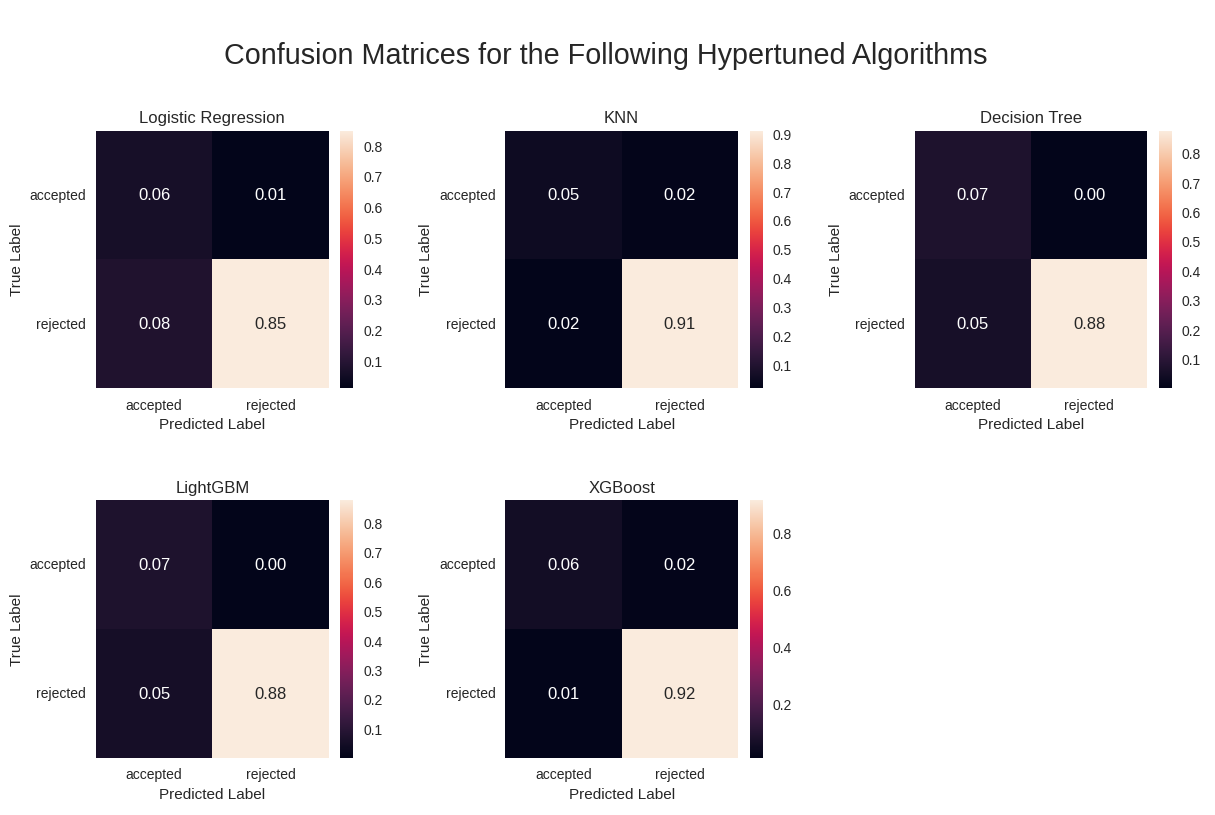

In [61]:
%reload_ext autoreload


lfunc.plot_confusion_matrices(model_prob_after,y_test,
                              names = classifiers,
                              n_cols = 3, normalize = 'all', labels = labels,
                              title = 'for the Following Hypertuned Algorithms')

## Ensemble

### Voting Classifier

In [62]:
%%time
%reload_ext autoreload

classifiers_vot = classifiers_h.copy()

to_exclude = ['Linear Svm','Radial Svm',
             'Logistic Regression',
             #'KNN',
             #'Decision Tree', 'Random Forest',
             #'LightGBM', 'XGBoost'
              ]
for item in to_exclude:
    if item in classifiers_vot:
        classifiers_vot.remove(item)

estimators_vot = []
for clas in classifiers_vot:
    estimators_vot.append(classifier_map_h[clas])

estimators_list = list(zip(classifiers_vot,estimators_vot))

# Need to remove XGBoost because it needs fit_params for early stopping
# - unclear how to implement this without crashing
if 'XGBoost' in classifiers_vot:
    index = classifiers_vot.index('XGBoost')
    estimators_list.pop(index)

vot_clas = VotingClassifier(estimators = estimators_list,
                            voting='soft')

pipe_steps = pipe_prep_steps.copy()
pipe_steps.append(('vot_classifiers' , vot_clas))

vot_pipe = Pipeline(pipe_steps)

vot_perf, vot_results, vot_prob = lfunc.model_scores(X_train,y_train,X_test,
                                                     models = [vot_pipe],
                                                     model_names = ['vot_classifiers'],
                                                     cv = cvRSK)


Executing vot_classifiers
Done!
CPU times: user 18.1 s, sys: 252 ms, total: 18.3 s
Wall time: 16.2 s


In [63]:
vot_perf.round(3)

,accuracy mean,accuracy std,balanced accuracy mean,balanced accuracy std,f1 mean,f1 std,f1 micro mean,f1 micro std,f1 macro mean,f1 macro std,f1 weighted mean,f1 weighted std,precision mean,precision std,precision micro mean,precision micro std,precision macro mean,precision macro std,precision weighted mean,precision weighted std,average precision mean,average precision std,recall mean,recall std,recall micro mean,recall micro std,recall macro mean,recall macro std,recall weighted mean,recall weighted std,roc auc mean,roc auc std,roc auc ovr mean,roc auc ovr std,roc auc ovo mean,roc auc ovo std,roc auc ovr weighted mean,roc auc ovr weighted std,roc auc ovo weighted mean,roc auc ovo weighted std
vot_classifiers,0.968,0.005,0.952,0.012,0.983,0.003,0.968,0.005,0.896,0.013,0.97,0.004,0.995,0.002,0.968,0.005,0.855,0.018,0.975,0.003,0.999,0.0,0.971,0.005,0.968,0.005,0.952,0.012,0.968,0.005,0.992,0.002,0.992,0.002,0.992,0.002,0.992,0.002,0.992,0.002


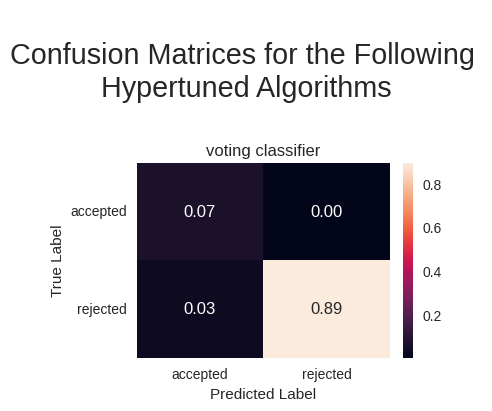

In [64]:
%reload_ext autoreload

lfunc.plot_confusion_matrices(vot_prob, y_test,
                              names = ['voting classifier'],
                              n_cols = 1, normalize = 'all',
                              threshold = 0.5, labels = labels,
                              title = 'for the Following \nHypertuned Algorithms')

### Bagging

In [65]:
%%time
%reload_ext autoreload

# XGBoost issues with fit_params again...

clf_name = 'Decision Tree'
clf = classifier_map_h[clf_name]

index = classifiers_h.index(clf_name)
fit_params = fit_params_hyped[index]

bag_name = 'bag_'+clf_name.replace(' ', '_')
bag_clas = BaggingClassifier(base_estimator=clf,random_state=0,n_estimators=100)

pipe_steps = pipe_prep_steps.copy()
pipe_steps.append((bag_name , bag_clas))
bag_pipe = Pipeline(pipe_steps)

bag_perf, bag_results, bag_prob = lfunc.model_scores(X_train, y_train, X_test,
                                                     models = [bag_pipe],
                                                     model_names = [bag_name],
                                                     cv = cvRSK)


Executing bag_Decision_Tree
Done!
CPU times: user 48.4 s, sys: 247 ms, total: 48.6 s
Wall time: 49.5 s


In [66]:
bag_perf.round(3)

,accuracy mean,accuracy std,balanced accuracy mean,balanced accuracy std,f1 mean,f1 std,f1 micro mean,f1 micro std,f1 macro mean,f1 macro std,f1 weighted mean,f1 weighted std,precision mean,precision std,precision micro mean,precision micro std,precision macro mean,precision macro std,precision weighted mean,precision weighted std,average precision mean,average precision std,recall mean,recall std,recall micro mean,recall micro std,recall macro mean,recall macro std,recall weighted mean,recall weighted std,roc auc mean,roc auc std,roc auc ovr mean,roc auc ovr std,roc auc ovo mean,roc auc ovo std,roc auc ovr weighted mean,roc auc ovr weighted std,roc auc ovo weighted mean,roc auc ovo weighted std
bag_Decision_Tree,0.961,0.005,0.958,0.01,0.979,0.003,0.961,0.005,0.879,0.012,0.964,0.004,0.996,0.002,0.961,0.005,0.828,0.015,0.972,0.002,0.999,0.0,0.961,0.005,0.961,0.005,0.958,0.01,0.961,0.005,0.992,0.003,0.992,0.003,0.992,0.003,0.992,0.003,0.992,0.003


CPU times: user 262 ms, sys: 121 ms, total: 382 ms
Wall time: 275 ms


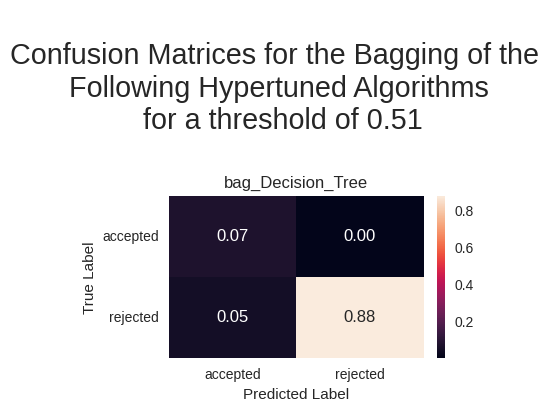

In [67]:
%%time
%reload_ext autoreload

thresh = 0.51
title = 'for the Bagging of the \n Following Hypertuned Algorithms \
\n for a threshold of '+ str(thresh)

lfunc.plot_confusion_matrices(bag_prob, y_test,
                              names = [bag_name],
                              n_cols = 1, normalize = 'all',
                              threshold = thresh, labels = labels,
                              title = title)

## ROCAUC, Precisions-Recall curve and Discrimination Threshold

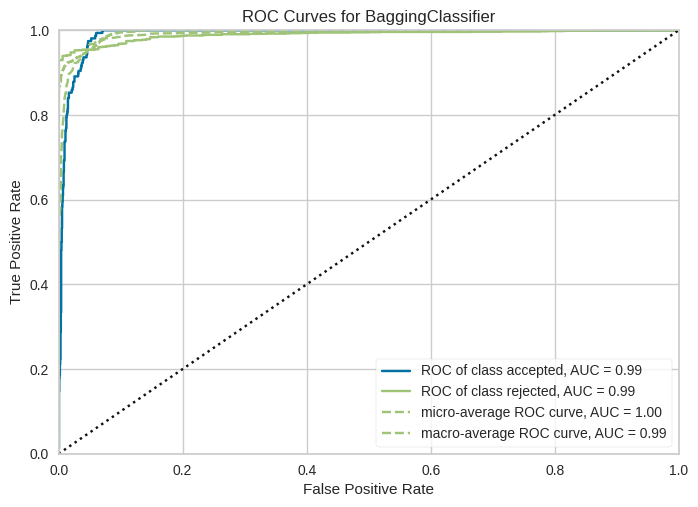

In [68]:
model_pipe = bag_pipe
#model_pipe = pipe

model_pipe.fit(X_train, y_train)

visualizer = ROCAUC(model_pipe, classes= LE.classes_)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show();

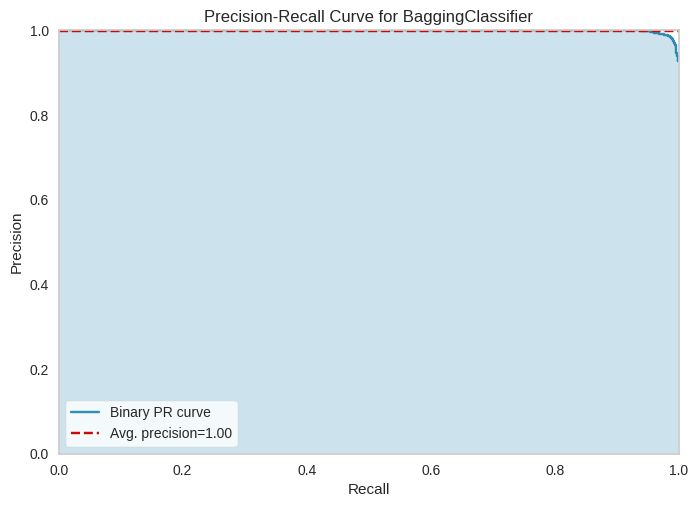

In [69]:
# does not work with LightGBM
viz = PrecisionRecallCurve(model_pipe, classes= LE.classes_)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show();

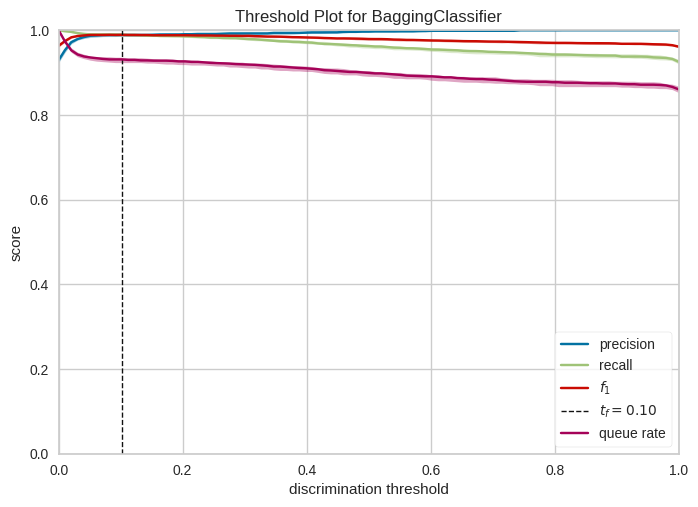

In [70]:
# not supported for multiclass
visualizer = DiscriminationThreshold(model_pipe, quantiles=np.array([0.25, 0.5, 0.75]))

visualizer.fit(X_train, y_train)
visualizer.show();

In [71]:
# needs results from DiscriminationThreshold - not supported for multiclass

best_threshold = visualizer.thresholds_[visualizer.cv_scores_[visualizer.argmax].argmax()].round(3)
print('best_threshold:', best_threshold.round(3))
thresh_pipe = Thresholder(bag_pipe, best_threshold, refit=False)

thresh_pipe.fit(X_train, y_train)

best_threshold: 0.102


Thresholder(model=Pipeline(steps=[('preprocessor',
                                   ColumnTransformer(remainder='passthrough',
                                                     transformers=[('num',
                                                                    Pipeline(steps=[('imputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('scaler',
                                                                                     StandardScaler())]),
                                                                    ['Amount '
                                                                     'Requested',
                                                                     'Risk_Score',
                                                                     'dti']),
                                                                   ('cat',
                                                                    Pipeline(steps=[('imputer',
                                                                                     SimpleImputer(strategy='most_frequent')),
                                                                                    ('encoder',
                                                                                     OneHotEncoder(hand...
                                                                                                                 'year',
                                                                                                                 '2 '
                                                                                                                 'years',
                                                                                                                 '3 '
                                                                                                                 'years',
                                                                                                                 '4 '
                                                                                                                 'years',
                                                                                                                 '5 '
                                                                                                                 'years',
                                                                                                                 '6 '
                                                                                                                 'years',
                                                                                                                 '7 '
                                                                                                                 'years',
                                                                                                                 '8 '
                                                                                                                 'years',
                                                                                                                 '9 '
                                                                                                                 'years',
                                                                                                                 '10+ '
                                                                                                                 'years']]))]),
                                                                    ['Employment '
                                                                     'Length'])])),
                                  ('bag_Decision_Tree',
                                   BaggingCl

CPU times: user 259 ms, sys: 121 ms, total: 380 ms
Wall time: 267 ms


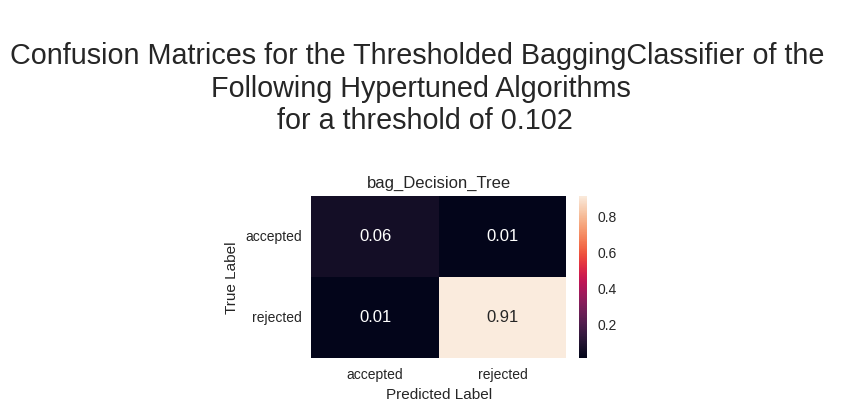

In [72]:
%%time
%reload_ext autoreload

thresh = 0.51
title = 'for the Thresholded BaggingClassifier of the \n Following Hypertuned Algorithms \
\n for a threshold of '+ str(best_threshold)


thresh_prob = thresh_pipe.predict_proba(X_test)

lfunc.plot_confusion_matrices([thresh_prob], y_test,
                              names = [bag_name],
                              n_cols = 1, normalize = 'all',
                              threshold = best_threshold, labels = labels,
                              title = title)

Decision Tree qith threshold 0.23 --> unexpectedly good


## Explainability

### Permutation Importance

In [73]:
X_test_transformed = pd.DataFrame(bag_pipe[:-1].transform(X_test), columns=new_cols)

perm = PermutationImportance(bag_clas,
                             n_iter = 5, random_state=1
                             ).fit(X_test_transformed, y_test)
eli5.show_weights(perm, feature_names = new_cols)

Weight,Feature
0.0857 ± 0.0067,num__Risk_Score
0.0161 ± 0.0055,num__dti
0.0143 ± 0.0045,ord__Employment Length
0.0023 ± 0.0048,num__Amount Requested


In [74]:
%%time
%reload_ext autoreload

clf_name = 'LightGBM'
index = classifiers.index(clf_name)
pipe = models_hyped[index]

model_pipe = pipe
model_pipe.fit(X_train, y_train)
X_test_transformed = pd.DataFrame(model_pipe[:-1].transform(X_test), columns=new_cols)

perm = PermutationImportance(model_pipe[-1], scoring=scoring,
                             n_iter = 5, random_state=1
                             ).fit(X_test_transformed, y_test)
eli5.show_weights(perm, feature_names = new_cols)

CPU times: user 411 ms, sys: 23.9 ms, total: 435 ms
Wall time: 442 ms


Weight,Feature
0.4265 ± 0.0237,num__Risk_Score
0.1199 ± 0.0301,num__dti
0.0325 ± 0.0067,ord__Employment Length
0.0036 ± 0.0041,num__Amount Requested


### SHAP evaluation

In [75]:
# cannot work on BaggedClassifier

#does not work for LightGBM, XGBoost (wrappers?), KNN

clf_name = 'Logistic Regression'
index = classifiers.index(clf_name)
pipe = models_hyped[index]

model_pipe = pipe
#model_pipe = models_hyped[2] # LogReg
model_pipe.fit(X_train, y_train)

X_test_transformed = np.array(model_pipe[:-1].transform(X_test))
X_train_transformed = np.array(model_pipe[:-1].fit_transform(X_train))

explainer = shap.Explainer(model_pipe[-1], X_train_transformed,
                           feature_names=new_cols, )
shap_values = explainer(X_test_transformed) #, check_additivity=False)


In [76]:
shap_values

.values =
array([[ 5.03462159e-02, -4.01591871e-01, -2.62774781e-01,
         3.27771424e-01],
       [-3.37685896e-02, -1.06979798e+00, -2.15647806e-01,
        -1.35310767e+00],
       [ 1.27924600e-03,  8.35190814e+00, -1.03836437e-02,
         3.27771424e-01],
       ...,
       [-4.07781568e-02,  1.46938523e+00, -5.96051519e-02,
         3.27771424e-01],
       [-6.18068582e-02, -4.01591871e-01, -3.50221503e-01,
        -1.77332745e+00],
       [ 1.55489723e-01, -4.01591871e-01, -3.02134534e-01,
         3.27771424e-01]])

.base_values =
array([2.65710712, 2.65710712, 2.65710712, ..., 2.65710712, 2.65710712,
       2.65710712])

.data =
array([[ 0.44671644,  0.07624701, -0.05674088,  0.        ],
       [-0.35557175,  0.27688602, -0.05362927,  4.        ],
       [-0.021285  , -2.55212403, -0.04007646,  0.        ],
       ...,
       [-0.42242909, -0.48554222, -0.04332637,  0.        ],
       [-0.62300114,  0.07624701, -0.06251466,  5.        ],
       [ 1.44957667,  0.07624701,

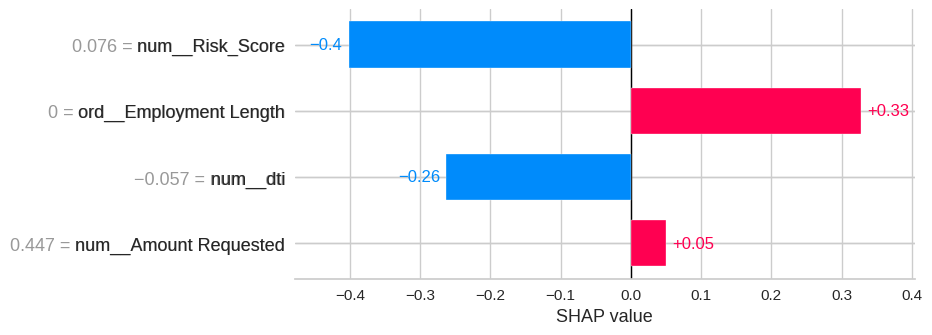

In [77]:
shap.initjs()
shap.plots.bar(shap_values[0])

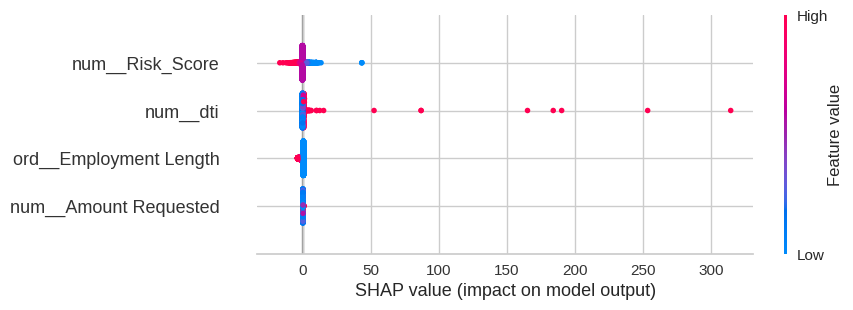

In [78]:
shap.plots.beeswarm(shap_values)

In [79]:
shap.initjs()

shap.plots.force(shap_values[1])

In [80]:
clustering = shap.utils.hclust(X_test_transformed, y_test)

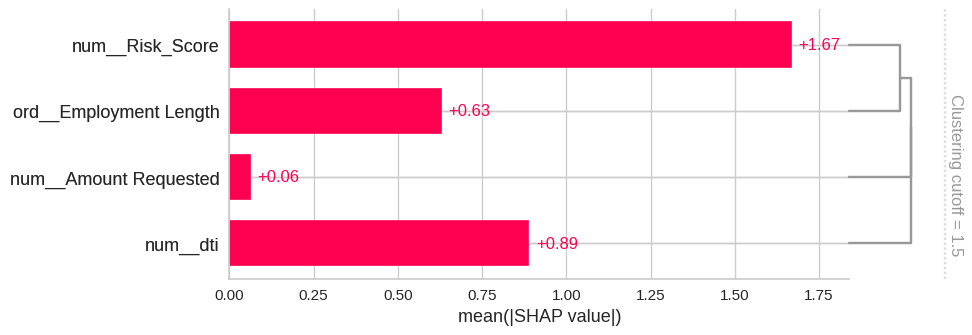

In [81]:
shap.plots.bar(shap_values, clustering = clustering, clustering_cutoff = 1.5)

## Final Model

In [82]:
#stroke_LogReg_model = models_hyped[2]
final_model = bag_pipe

In [83]:
final_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Amount Requested',
                                                   'Risk_Score', 'dti']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')...
                                                                   OrdinalEncoder(categories=[['< '
                                                                                               '1 '
                                                                                               'year',
                                                                                               '1 '
                                                                                               'year',
                                                                                               '2 '
                                                                                               'years',
                                                                                               '3 '
                                                                                               'years',
                                                                                               '4 '
                                                                                               'years',
                                                                                               '5 '
                                                                                               'years',
                                                                                               '6 '
                                                                                               'years',
                                                                                               '7 '
                                                                                               'years',
                                                                                               '8 '
                                                                                               'years',
                                                                                               '9 '
                                                                                               'years',
                                                                                               '10+ '
                                                                                               'years']]))]),
                                                  ['Employment Length'])])),
                ('bag_Decision_Tree',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                         min_samples_leaf=6,
                                                                         min_samples_split=40,
                                                                         random_state=1),
                                   n_estimators=100, random_state=0))])

In [84]:
filename = home_folder+'loan_acceptance_Bagged_model.pickle'
pickle.dump(final_model,open(filename, 'wb'))

# Summary

# Improvements

**General**

Feature selection/Cleaning
* less strict on mulitcolinearity
* Less strict on dropping but freq-%
* reduce/bundle classes of features
* Missing values in categoricals: Own class instead of * imputing
* software, e.g. Boruta
* use logarithmic features


Models and Optimization
* try other model, e.g. CatBoost
* failed attempts: TuneSearchCV (internal bugs), * OptunaSearchCV
* Auto-sklearn (grade prediction - not yet finding solutions)

.

**Model-specific**

Linear Regression
* clip outliers

Regression/Classifier Trees
* omit scaling of numericals

Loan acceptance
* Language processing of 'loan_title' → purpose

Grade/Sub-grade
* Classifiers: change class weights manually in estimators
* Linear Regression on ordinal target
* Ordinal Logistic Regression




#### PCA

In [85]:
X_train[num_feat].columns

Index(['Amount Requested', 'Risk_Score', 'dti'], dtype='object')

In [86]:
num_feat = X_train.select_dtypes(include=np.number).columns.tolist()

transformers=[("num", numeric_transformer, num_feat),
              ]

preprocessor_pca = ColumnTransformer(transformers=transformers,
                                 remainder='passthrough'
                                 )

In [87]:
from sklearn.decomposition import PCA

pca = PCA()
pca_pipe = Pipeline([('preprocessor', preprocessor_pca),
                     ("pca", pca)
                                  ])

In [88]:
X_transformed = pca_pipe.fit_transform(X_train[num_feat])

final = pd.DataFrame(X_transformed[:,:2], columns=['first_component', 'second_component'])

pca_pipe.named_steps['pca'].explained_variance_ratio_


array([0.37250176, 0.33250621, 0.29499202])

In [90]:
best_cat_feat = features
final = pd.merge(X_train_analysis[best_cat_feat],
                 final, left_index=True, right_index=True)
final.head()

,Amount Requested,Risk_Score,Employment Length,dti,first_component,second_component
7041,4100.0,NaN,5 years,42.37,-0.106044,-0.009182
1358,10000.0,NaN,< 1 year,274.23,-0.005920,-0.033274
569,7000.0,NaN,< 1 year,14.96,-0.012085,-0.021869
8044,6500.0,NaN,< 1 year,16.09,-0.065945,-0.016104
7274,20000.0,706.0,< 1 year,14.83,-0.248609,-0.001044


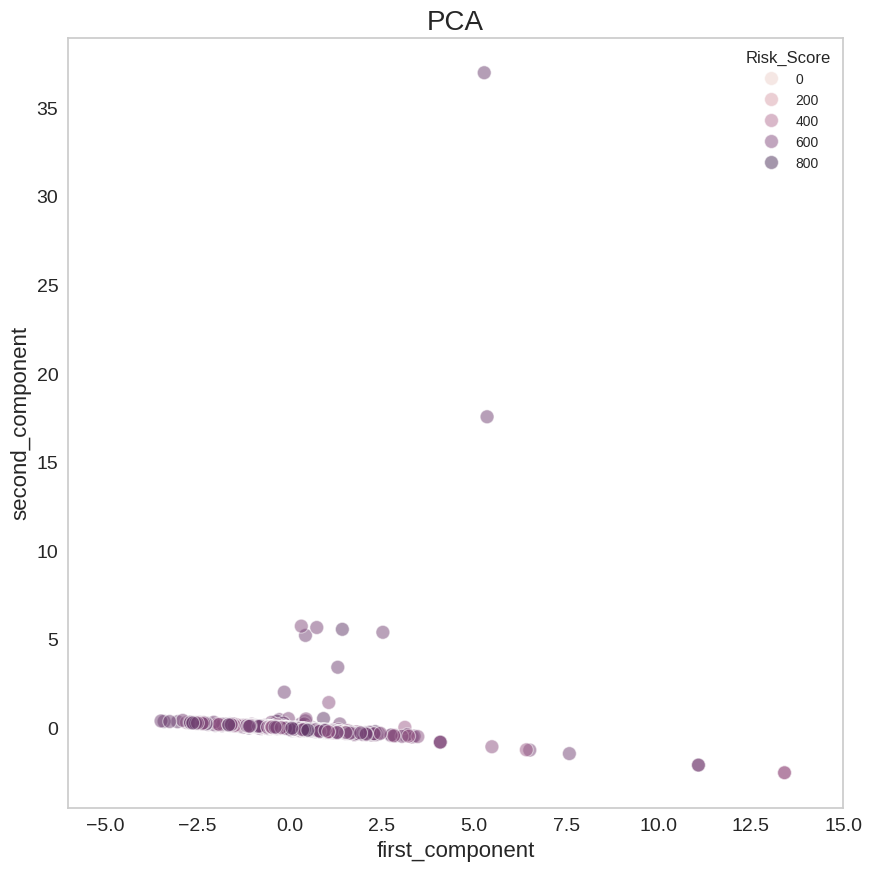

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

hue_list= best_cat_feat
hue = hue_list[1]

fig = sns.scatterplot(final, x='first_component', y='second_component', s=100,
                     alpha=0.5, hue = hue,
                      ax=ax)

ax.set_title('PCA', size=20)
ax.set_xlabel('first_component', size=16)
ax.set_ylabel('second_component', size=16)
ax.tick_params(labelsize=14)
ax.set_xlim(-6, 15)
ax.grid(False)


In [92]:

from matplotlib.patches import Circle
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances


In [93]:
#Xstd = StandardScaler().fit_transform(X)
#pca = PCA(n_components=2)
Xpca = pca_pipe.fit_transform(X_train)

ValueError: could not convert string to float: '5 years'

In [94]:
len(Xpca)

NameError: name 'Xpca' is not defined

In [ ]:
eucl_dist = []
for i,j in enumerate(X_train .T):
    corr1 = np.corrcoef(j,Xpca[:,0])[0,1]
    corr2 = np.corrcoef(j,Xpca[:,1])[0,1]
    circle.append((corr1, corr2))
    eucl_dist.append(np.sqrt(corr1**2 + corr2**2))

In [ ]:
with plt.style.context(('seaborn-whitegrid')):
    fig, axs = plt.subplots(figsize=(6, 6))
    for i,j in enumerate(eucl_dist):
        arrow_col = plt.cm.cividis((eucl_dist[i] - np.array(eucl_dist).min())/\
                                (np.array(eucl_dist).max() - np.array(eucl_dist).min()) )
        axs.arrow(0,0, # Arrows start at the origin
                 ccircle[i][0],  #0 for PC1
                 ccircle[i][1],  #1 for PC2
                 lw = 2, # line width
                 length_includes_head=True,
                 color = arrow_col,
                 fc = arrow_col,
                 head_width=0.05,
                 head_length=0.05)
        axs.text(ccircle[i][0]/2,ccircle[i][1]/2, iris.feature_names[i])
    # Draw the unit circle, for clarity
    circle = Circle((0, 0), 1, facecolor='none', edgecolor='k', linewidth=1, alpha=0.5)
    axs.add_patch(circle)
    axs.set_xlabel("PCA 1")
    axs.set_ylabel("PCA 2")
plt.tight_layout()
plt.show()

In [ ]:

X_pca = pca_pipe.fit_transform(X_train)
total_explained_variance = pca_pipe['pca'].explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance >= .95])
n_to_reach_95 = X_pca.shape[1] - n_over_95 + 1
print('Number features: {}\tTotal Variance Explained: {}'.format(n_to_reach_95, total_explained_variance[n_to_reach_95-1]))



In [ ]:
X_train_analysis.columns

In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

#df = px.data.iris()
features = X_train_analysis.columns.tolist() #['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
#X = df[features]

#pca = PCA(n_components=2)
components = pca_pipe.fit_transform(X_train)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=X_train_analysis['loan_status_simple'])

for i, feature in enumerate(features):
    fig.add_annotation(
        ax=0, ay=0,
        axref="x", ayref="y",
        x=loadings[i, 0],
        y=loadings[i, 1],
        showarrow=True,
        arrowsize=2,
        arrowhead=2,
        xanchor="right",
        yanchor="top"
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        yshift=5,
    )
fig.show()


In [ ]:
from yellowbrick.features import PCA

#selected_feat= final_multicol_reduced_feat + cat_feat
#
#X = LCacc_PC_EDA[selected_feat]
#X = X.drop(columns=['grade', 'sub_grade', 'sub_grade', 'loan_status_simple', 'int_rate'])
#y = LCacc_PC_EDA['int_rate'].to_frame()


visualizer = PCA(scale=False, proj_features=True, )
visualizer.fit_transform(X_train_prep)
visualizer.show()